# Data Science II CoderHouse [61695]

### Alumno: [Javier Alcoba]

## Análisis de una base de datos de Spotify. En particular, sobre qué artista es mejor, Ariana Grande o Ed Sheeran.

# Descripción del Problema
Para esto, se cuenta con una base de 26 millones de filas, en las cuales se dejará sólo información de los 2 artistas.

## Objetivo

El objetivo principal es el de analizar la base de datos, para poder obtener los datos necesarios para analizar las canciones que tuvo éxito de cada uno en los últimos años, así como la cantidad de reproducciones que tuvo su canción.
 
## Fuente

Los datos utilizados en este trabajo fueron obtenidos desde el siguiente link de Kaggle:
https://www.kaggle.com/datasets/dhruvildave/spotify-charts

## Importación de Librerías y Carga de Datos

In [6]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

#### Como no se puede compartir el archivo del dataset porque ocupa 3.54GB, se filtró el mismo para tener sólos los artistas Ed Sheeran y Ariana Grande, y sobre el mismo se tomó una muestra de 10000 filas, para poder guardar luego un dataset más fácil de compartir. Si se desea usar el dataset original, quitar los comentarios de los siguientes cuadros de código.


In [8]:
# Se abre la base de datos
# df = pd.read_csv('charts.csv')

In [9]:
# muestra = df[df['artist'].isin(['Ed Sheeran', 'Ariana Grande'])].copy()

In [10]:
# Filtrar el DataFrame para quedarnos solo con los artistas especificados
# df_filtrado = muestra.sample(n=10000, random_state=42)

In [11]:
# Dataset ligero con filtrado de artistas y muestra de 10000 filas a nro aleatorio 42, para su más fácil descarga
#d f_filtrado.to_csv('charts_artistas.csv', index=False)

## Exploración de Datos

### Preparación del dataset ligero a compartir

In [14]:
# Si se va a usar el dataset filtrado, agregar # a la siguiente línea:
df_filtrado = pd.read_csv('https://raw.githubusercontent.com/ajalcoba/Data_Scientist_II/refs/heads/main/charts_artistas.csv')

In [15]:
df_filtrado.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    10000 non-null  object 
 1   rank     10000 non-null  int64  
 2   date     10000 non-null  object 
 3   artist   10000 non-null  object 
 4   url      10000 non-null  object 
 5   region   10000 non-null  object 
 6   chart    10000 non-null  object 
 7   trend    10000 non-null  object 
 8   streams  9340 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 703.3+ KB


#### Como se puede observar, el dataset de muestra tiene 10000 filas, contrario al original, que cuenta con 26 millones de filas

### Valores Faltantes
Se revisará el dataframe de los 2 artistas, para ver si tiene datos faltantes

In [18]:
df_filtrado.isnull().sum()

title        0
rank         0
date         0
artist       0
url          0
region       0
chart        0
trend        0
streams    660
dtype: int64

In [19]:
df_filtrado.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    10000 non-null  object 
 1   rank     10000 non-null  int64  
 2   date     10000 non-null  object 
 3   artist   10000 non-null  object 
 4   url      10000 non-null  object 
 5   region   10000 non-null  object 
 6   chart    10000 non-null  object 
 7   trend    10000 non-null  object 
 8   streams  9340 non-null   float64
dtypes: float64(1), int64(1), object(7)
memory usage: 703.3+ KB


#### Como la columna streams tiene faltantes, y estos representan el 6% del total, se podrían haber eliminado. No obstante, siendo que se trata de la columna de vistas, se puede hacer una solución que aporte más que eliminando la columna. Asumiento estos valores se encuentren distribuidos en todas las canciones, existe una alta probabilidad de poder tomar datos de vistas de dicha canción de otro día arbitrario (bajo el mismo país (región)) y así fijar un valor medio. Luego se verificará si quedó algún elemento que no contó con información previa o posterior (a esos valores se los dejará en 1000, puesto que 1001 era el valor mínimo de streams.

In [21]:
# Agrupar por región, título y artista, y calcular el promedio de streams
def calcular_promedio_por_grupo(df):
    promedios_por_grupo = df.groupby(['region', 'title'])['streams'].agg(['mean', 'count']).reset_index()
    
    # Filtrar los grupos donde el conteo es mayor que 0 (es decir, que hay al menos un valor numérico)
    promedios_por_grupo = promedios_por_grupo[promedios_por_grupo['count'] > 0]
    return promedios_por_grupo


# Rellenar los NaN en el DataFrame original con los promedios correspondientes.
def rellenar_nan(row):
    region, title = row['region'], row['title']
    result = promedios_por_grupo[(promedios_por_grupo['region'] == region) &
                                 (promedios_por_grupo['title'] == title)]['mean']
    return result.values[0] if not result.empty else 1000

In [22]:
# Obtengo la variable promedios_por_grupo, esta vez, sin valores NaN
promedios_por_grupo = calcular_promedio_por_grupo(df_filtrado)

#### Para estar seguros que sólo se reemplacen los valores NaN de la muestra tomada, se creará una copia de la muestra y se verificará que las diferencias entre los valores de los dataframes para la columna 'streams' sean el mismo nro que el de NaN encontrados a usar la función. Revisando, deberían ser 37402 cambios.

In [24]:
# Crear una copia del dataframe para evitar modificar el dataframe original
df_copia = df_filtrado.copy()

# Crear una máscara para identificar los NaN en la columna 'streams'
mask = df_filtrado['streams'].isnull()

# Aplicar la función de relleno solo a las filas donde la máscara es True
df_filtrado.loc[mask, 'streams'] = df_filtrado[mask].apply(rellenar_nan, axis=1)

# Comparar las columnas
diferencias = df_filtrado['streams'] != df_copia['streams']
print("Filas donde se modificó el valor de 'streams':")
print(df_filtrado[diferencias])

# Verificar si todos los valores NaN han sido reemplazados
print("Número de valores NaN después de la imputación:", df_filtrado['streams'].isnull().sum())

Filas donde se modificó el valor de 'streams':
                                               title  rank        date  \
22                                           Perfect    48  2017-12-03   
39    Perfect Symphony (Ed Sheeran & Andrea Bocelli)     3  2017-12-21   
67                                     thank u, next    35  2019-02-08   
86                                           7 rings    38  2019-03-15   
109   Perfect Symphony (Ed Sheeran & Andrea Bocelli)    11  2017-12-24   
...                                              ...   ...         ...   
9945               Stuck with U (with Justin Bieber)    23  2020-08-06   
9952                            no tears left to cry    29  2018-05-03   
9960                 Beautiful People (feat. Khalid)    37  2019-09-19   
9991                                   thank u, next     2  2018-12-21   
9996               Stuck with U (with Justin Bieber)    34  2020-06-07   

             artist                                             

#### Como se puede ver, no se tocaron los datos válidos. Sólo los datos NaN

In [26]:
df_filtrado.isnull().sum()

title      0
rank       0
date       0
artist     0
url        0
region     0
chart      0
trend      0
streams    0
dtype: int64

In [27]:
(df_filtrado['streams'] == 1000).sum()

127

#### Como se puede observar, el 93% de los datos faltantes pudo reemplazarse por un valor medio, dejando al 7% restante en un valor menor pero cercano al mínimo de reproducciones.

## Cambio los datos de date, de objeto a fecha

In [30]:
df_filtrado['date'] = pd.to_datetime(df_filtrado['date'])

## Creo columnas de interes

In [32]:
df_filtrado["year"] = df_filtrado["date"].dt.year

In [33]:
df_filtrado["quarter"] = df_filtrado["date"].dt.to_period('Q')

In [34]:
df_filtrado["year_month"] = df_filtrado["date"].dt.to_period('M')

In [35]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   title       10000 non-null  object        
 1   rank        10000 non-null  int64         
 2   date        10000 non-null  datetime64[ns]
 3   artist      10000 non-null  object        
 4   url         10000 non-null  object        
 5   region      10000 non-null  object        
 6   chart       10000 non-null  object        
 7   trend       10000 non-null  object        
 8   streams     10000 non-null  float64       
 9   year        10000 non-null  int32         
 10  quarter     10000 non-null  period[Q-DEC] 
 11  year_month  10000 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(6), period[M](1), period[Q-DEC](1)
memory usage: 898.6+ KB


# Análisis Exploratorio de datos

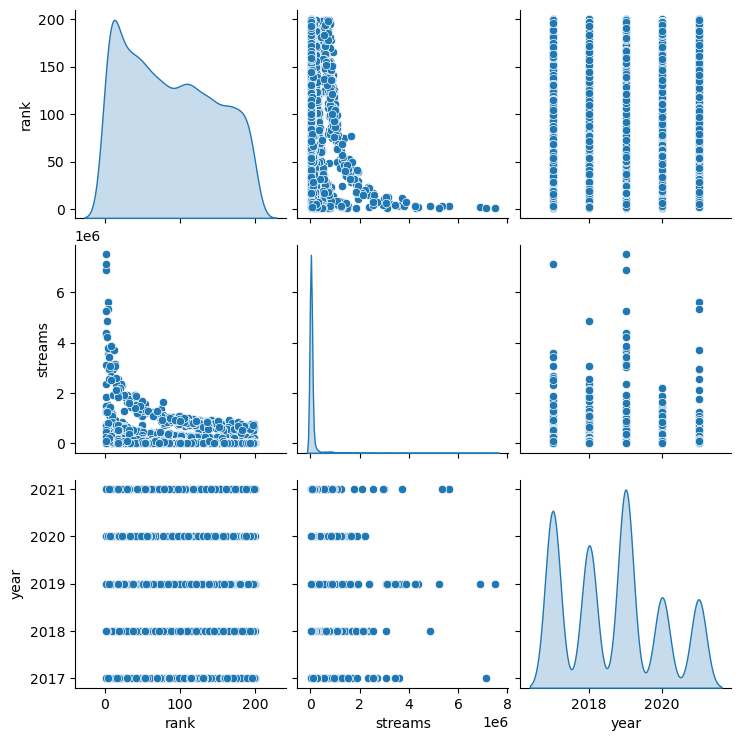

In [37]:
sns.pairplot(df_filtrado, diag_kind="kde")

#### Sólo se tiene valores en las columnas rank (posición en ranking regional) y streams (cantidad de visitas), así como la creada automáticamente

# Hipótesis de Ed Sheeran vs Ariana Grande

#### 1) Quién tiene más reproducciones?
#### 2) Cuál de los 2 artistas crea más canciones por año?
#### 3) El ranking de una canción, es directamente proporcional a la cantidad de reproducciones que tiene dicha canción?

### Análisis de nube de palabras para verificar qué palabras usan más en los nombres de las canciones que crean

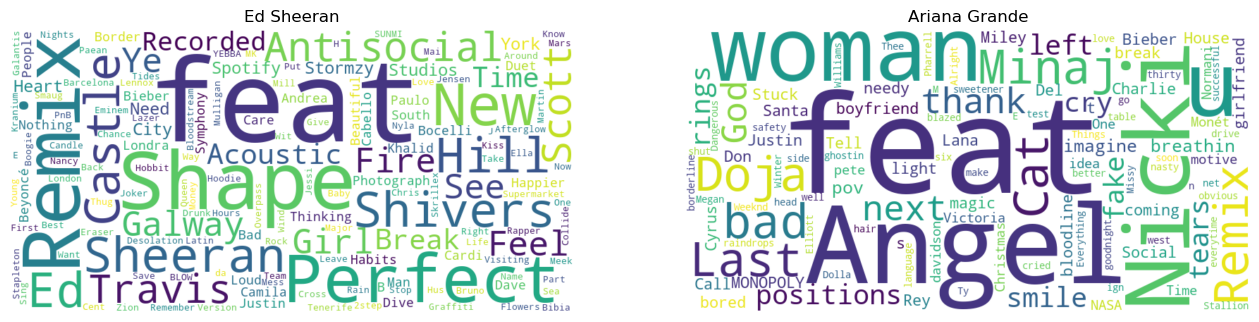

In [42]:
# Filtrar los datos para Ed Sheeran y Ariana Grande
ed_sheeran_df0 = df_filtrado[df_filtrado['artist'] == 'Ed Sheeran']
ariana_grande_df0 = df_filtrado[df_filtrado['artist'] == 'Ariana Grande']

# Crear una lista de palabras únicas para cada artista
ed_sheeran_words = ' '.join(ed_sheeran_df0['title'].unique())
ariana_grande_words = ' '.join(ariana_grande_df0['title'].unique())

# Crear las nubes de palabras
wordcloud_ed = WordCloud(width=800, height=400, background_color='white').generate(ed_sheeran_words)
wordcloud_ariana = WordCloud(width=800, height=400, background_color='white').generate(ariana_grande_words)

# Mostrar las nubes de palabras lado a lado
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_ed, interpolation='bilinear')
plt.axis("off")
plt.title("Ed Sheeran")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ariana, interpolation='bilinear')
plt.axis("off")
plt.title("Ariana Grande")

plt.show()

#### Como se puede observar, las palabras más grandes usadas en canciones que se ven en ambos artistas son REMIX y feat. Esto indica que está de moda sacar versiones remixadas de las canciones de cada uno, así como canciones que sean cantadas con un artista invitado

# Cantidad de países en los que está presente Ed Sheeran vs Ariana Grande

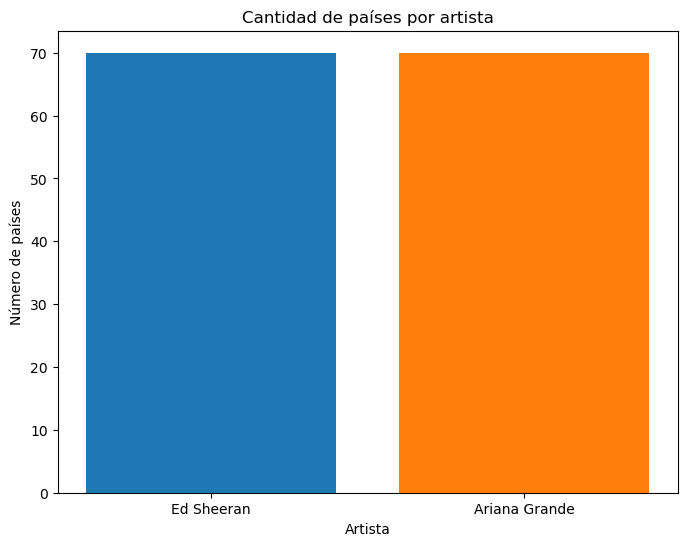

In [45]:
# Filtrar los datos para Ed Sheeran y Ariana Grande
ed_sheeran_df1 = df_filtrado[df_filtrado['artist'] == 'Ed Sheeran'].copy()
ariana_grande_df1 = df_filtrado[df_filtrado['artist'] == 'Ariana Grande'].copy()

# Contar la cantidad de países únicos para cada artista
num_paises_ed_sheeran = ed_sheeran_df1['region'].nunique()
num_paises_ariana_grande = ariana_grande_df1['region'].nunique()

# Crear un DataFrame para el gráfico
data = {'Artista': ['Ed Sheeran', 'Ariana Grande'],
        'Número de países': [num_paises_ed_sheeran, num_paises_ariana_grande]}
df_plot = pd.DataFrame(data)

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(df_plot['Artista'], df_plot['Número de países'], color=['#1F77B4', '#FF7F0E'])
plt.xlabel('Artista')
plt.ylabel('Número de países')
plt.title('Cantidad de países por artista')
plt.show()

#### Como se puede observar, no hay una diferencia notable en la cantidad de países que conocen a ambos artistas.

# Análisis de cantidad de canciones creadas por Ed Sheeran y Ariana Grande por año

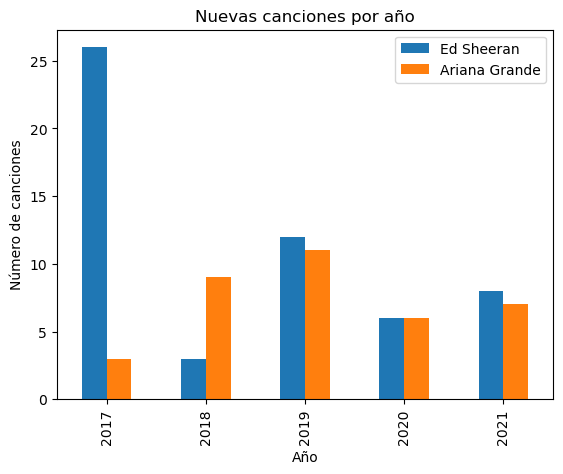

In [48]:
# Filtrar por Ed Sheeran y Ariana Grande
ed_sheeran_df2 = df_filtrado[df_filtrado['artist'] == 'Ed Sheeran'].copy()
ariana_grande_df2 = df_filtrado[df_filtrado['artist'] == 'Ariana Grande'].copy()

# Obtener los títulos únicos de las canciones nuevas para cada artista
unique_ed_sheeran_songs = ed_sheeran_df2[ed_sheeran_df2['trend'] == 'NEW_ENTRY'].drop_duplicates('title')
unique_ariana_grande_songs = ariana_grande_df2[ariana_grande_df2['trend'] == 'NEW_ENTRY'].drop_duplicates('title')

# Contar las nuevas canciones por año para cada artista
ed_sheeran_songs_per_year = unique_ed_sheeran_songs.groupby(unique_ed_sheeran_songs['year']).size()
ariana_grande_songs_per_year = unique_ariana_grande_songs.groupby(unique_ariana_grande_songs['year']).size()


# Crear un DataFrame para los resultados
results = pd.DataFrame({'Ed Sheeran': ed_sheeran_songs_per_year, 'Ariana Grande': ariana_grande_songs_per_year})

# Visualizar los resultados en un gráfico de barras
results.plot(kind='bar')
plt.title('Nuevas canciones por año')
plt.xlabel('Año')
plt.ylabel('Número de canciones')
plt.show()

#### Como se puede ver, ED Sheeran ha creado más canciones por año que Ariana Grande. Este detalle podría indicar que Ed Sheeran también tendría más reproducciones que Ariana Grande, aunque se tendrá que hacer un análisis distinto para determinar esto.

## Promedio de streams de Ed Sheeran vs Ariana Grande

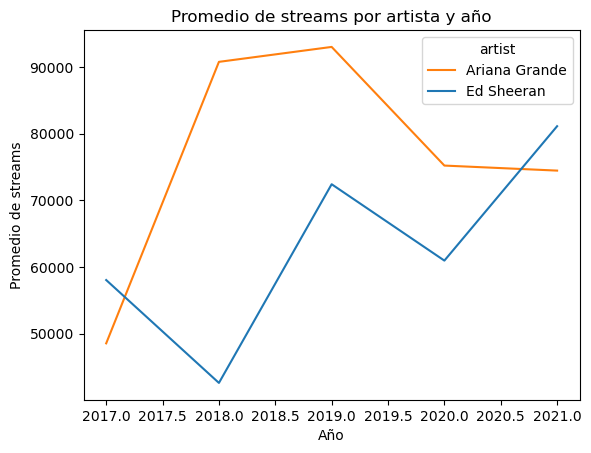

In [51]:
# Filtrar por los artistas Ed Sheeran y Ariana Grande
artistas_interes = ['Ed Sheeran', 'Ariana Grande']
df_filtrado2 = df_filtrado[df_filtrado['artist'].isin(artistas_interes)].copy()

# Agrupar y calcular el promedio
promedio_streams_por_artista_y_ano = df_filtrado2.groupby(['artist', 'year'])['streams'].mean().reset_index()

# Crear un gráfico de líneas
promedio_streams_por_artista_y_ano.pivot(index='year', columns='artist', values='streams').plot(kind='line', color=['#FF7F0E', '#1F77B4'])
plt.title('Promedio de streams por artista y año')
plt.xlabel('Año')
plt.ylabel('Promedio de streams')
plt.show()

#### Como se puede observar en el gráfico, una mayor cantidad de canciones nuevas por año no hace a una mayor fama. Ariana Grande ha dominado en cantidad de streams, a pesar de crear menos canciones por año. Recién en 2021 Ed Sheeran pudo superarla, aunque si el patrón se mantiene, se espera que baje en nuevos intervalos de tiempo. 

Análisis de variables Posición en el Ranking vs Reproducciones

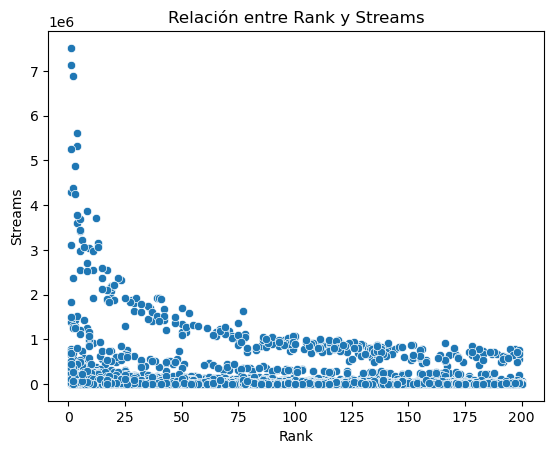

In [54]:
# Crear el diagrama de dispersión
sns.scatterplot(x='rank', y='streams', data=df_filtrado)
plt.title('Relación entre Rank y Streams')
plt.xlabel('Rank')
plt.ylabel('Streams')
plt.show()

#### Comportamiento raro del ranking de una canción vs la cantidad de visitas. Uno esperaría ver una correlación directa entre mayor ranking con mayor número de visitas, pero este no es el caso. La función parece asemejarse más a la de y = 1/x. Por otro lado, este comportamiento es normal, ya que a menor posición en el ranking, mejor posicionada estará la canción. La canción número 1 es la más escuchada y la que está en posición 200 es la menos escuchada. Interesante que la función sea de tipo y = 1/x, lo que implica que la relación es inversamente potencial. O sea, mientras más cerca de la posición 1 esté la canción, la cantidad de reproducciones aumenta en forma exponencial. Esto en principio valida la hipótesis, aunque fue mal expresada, por asumir que mayor ranking era mejor que menor ranking.

## Análisis de valores de media, cuartiles, desviación estándar y valores outliers

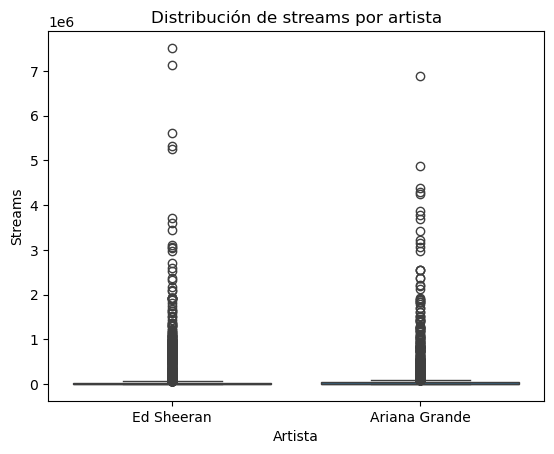

In [57]:
# Filtrar los datos para Ed Sheeran y Ariana Grande
ed_sheeran_df3 = df_filtrado[df_filtrado['artist'] == 'Ed Sheeran'].copy()
ariana_grande_df3 = df_filtrado[df_filtrado['artist'] == 'Ariana Grande'].copy()

# Create a DataFrame for Ed Sheeran
ed_sheeran_data = pd.DataFrame({'artist': 'Ed Sheeran', 'streams': ed_sheeran_df3['streams']})

# Create a DataFrame for Ariana Grande
ariana_grande_data = pd.DataFrame({'artist': 'Ariana Grande', 'streams': ariana_grande_df3['streams']})

# Concatenate the DataFrames
data = pd.concat([ed_sheeran_data, ariana_grande_data], ignore_index=True)


# Crear el box plot
sns.boxplot(x='artist', y='streams', data=data)
plt.title('Distribución de streams por artista')
plt.xlabel('Artista')
plt.ylabel('Streams')
plt.show()

#### La tremenda cantidad de datos outliers, en este caso, pueden significar lo que le pasa a mayoría de los músicos. Que no siempre sus canciones trinfan. Aun en el caso de artistas conocidos como Ed Sheeran y Ariana Grande, son pocas las canciones que más reproducciones tuvieron que las creadas por ellos, ya que la gran mayoría tienen una cantidad acotada de reproducciones, pero nada fuera de este mundo. La razón de que la media, cuartiles y desviación estándar se vean tan amontonados implica que, la media de canciones que hacen, así como las desviaciones calculadas en función de los datos, da a entender que las reproducciones estén en el orden de las decenas de miles de reproducciones. Luego, los valores outliers representan un universo claramente menor al mundo que definió los bigotes, y representan canciones que generaron una cantidad 1000 veces superior respecto a las reproducciones. Es decir, en el orden de las decenas de millones de reproducciones.

## Análisis de media, cuartiles, desviación estándar y outliers en grupos más acotados

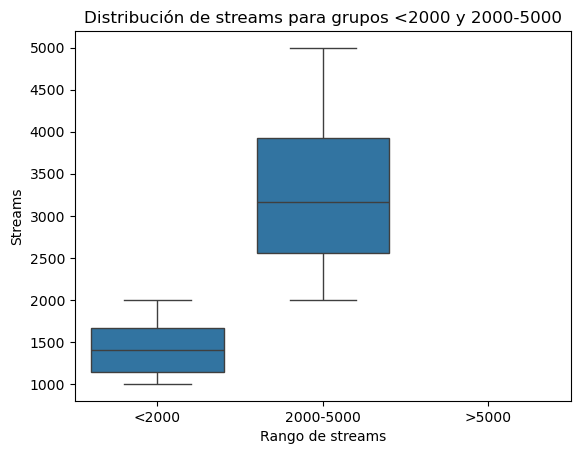

In [60]:
# Crear una nueva columna para categorizar los artistas
df_filtrado['grupo_streams'] = pd.cut(df_filtrado['streams'], bins=[0, 2000, 5000, np.inf],
                            labels=['<2000', '2000-5000', '>5000'])

# Filtrar los datos para los grupos 1 y 2, dejando fuera el grupo '>5000' que es el que hace que por proporción no se pueda ver bien el gráfico
df_filtrado = df_filtrado[df_filtrado['grupo_streams'].isin(['<2000', '2000-5000'])]

# Crear el gráfico de cajas
sns.boxplot(x='grupo_streams', y='streams', data=df_filtrado)
plt.title('Distribución de streams para grupos <2000 y 2000-5000')
plt.xlabel('Rango de streams')
plt.ylabel('Streams')
plt.show()

#### Para poder ver mejor el gráfico de bigotes, se crearon grupos de streams, y sólo se muestran los que cuentan con menos de 5000 reproducciones. En ellos se puede observar que el primer grupo,  que tiene menos de 2000 reproducciones, tiene una media y desviación pegada al mínimo de reproducciones, que es 1000, mientras que el máximo está en 1500 y los datos outliers están por encima de esto hasta 2000. Para el segundo grupo, de 2000 a 5000 reproducciones, se ve perfectamente el gráfico de bigotes, con sus extremos bien definidos. La media está en el entorno a las 3200 reproducciones, y su desviación estándar la ubica justo en el límite de 5000 reproducciones, que hace que no se puedan ver los datos outliers, pues están por encima de ese valor. También se puede observar que no se ven los outliers de menos de 2000, por pertenecer al rango de las menos de 2000 reproducciones.

## Análisis de datos usando algoritmos de Machine Learning

#### Librerías usadas en esta sección

In [64]:
# Librerías a usar para la ML
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix


## Creación de variable objetivo

#### Para probar modelos de machine learning de aprendizaje supervisado, se va a intentar crear una variable objetivo, en función de la información contenida en otra variable. La variable objetivo a crear será la Popularidad de una canción, con valores de tipo: Muy Popular (nro de vistas por encima del tercer cuartil), Algo Popular (nro de vistas entre primer y tercer cuartil) y Poco Popular (valroes por debajo del primer cuartil).


In [67]:
# Se crea una copia de dataframe para evitar algún daño accidental en el mismo
df_filtrado_artistas = df_filtrado.copy()

# Definir los umbrales para la variable objetivo basada en 'streams'
umbral_alto = df_filtrado_artistas['streams'].quantile(0.75)
umbral_bajo = df_filtrado_artistas['streams'].quantile(0.25)

# Se crea la variable objetivo 'popularidad'
def asignar_popularidad(streams):
    if streams >= umbral_alto:
        return 'Muy Popular'
    elif streams <= umbral_bajo:
        return 'Menos Popular'
    else:
        return 'Algo Popular'

df_filtrado_artistas['popularidad'] = df_filtrado_artistas['streams'].apply(asignar_popularidad)

#### A su vez, y para optimizar los valores obtenidos, se hará uso de Hiperpámetros, que sirven para controlar los parámetros que usan los algoritmos de machine learning, buscando encontrar los valores que puedan usarse para obtener el mejor resultado posible. Para esto, se utilizará la técnica de Randomize Search en el algoritmo de Random Forest.

In [69]:
# Detalle de los valores a usar para los hiperparámetros
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Preprocesamiento de datos
# Se codifican las variables categóricas de interés para el entrenamiento de la ML
le = LabelEncoder()
df_filtrado_artistas['title_encoded'] = le.fit_transform(df_filtrado_artistas['title'])
df_filtrado_artistas['artist_encoded'] = le.fit_transform(df_filtrado_artistas['artist'])
df_filtrado_artistas['region_encoded'] = le.fit_transform(df_filtrado_artistas['region'])
df_filtrado_artistas['chart_encoded'] = le.fit_transform(df_filtrado_artistas['chart'])
df_filtrado_artistas['trend_encoded'] = le.fit_transform(df_filtrado_artistas['trend'])

# Se seleccionan las  características y la variable objetivo
X = df_filtrado_artistas[['title_encoded', 'artist_encoded', 'region_encoded', 'chart_encoded', 'trend_encoded']]
y = df_filtrado_artistas['popularidad']

# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Preparación de random search para la elección aleatoria de los valores para cada hiperparámetro
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=5, class_weight='balanced'),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=5
)

# Entrenamiento usando los parámetros que entrega randomsearch
random_search.fit(X_train, y_train)

# Listado de los mejores hiperparámetrtos encontrados
print("Mejores hiperparámetros:", random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}


#### Ahora, se utilizará el algoritmo de Random Forest para intentar predeción la "popularidad" de una canción de Ed Sheeran o Ariana Grande, en función de los datos que contiene el dataframe.

In [71]:
# Entrenar un modelo de clasificación de bosque aleatorio
model = RandomForestClassifier(
    n_estimators=75,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=30,
    random_state=5
)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy}')
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.6107871720116618
               precision    recall  f1-score   support

 Algo Popular       0.62      0.68      0.65       346
Menos Popular       0.60      0.56      0.58       175
  Muy Popular       0.59      0.53      0.56       165

     accuracy                           0.61       686
    macro avg       0.61      0.59      0.60       686
 weighted avg       0.61      0.61      0.61       686



#### Como se puede observar, se nota que el algoritmo de random forest no tuvo mucho éxito en lo referido a predecir la popularidad de una canción. Esto se estima se debe a que en el ámbito de la música, es muy difícil predecir la popularidad que tendrá una canción. Aún más en datasets como este, que ni siquiera tiene la columna de tipo de música, aunque tenerla no necesariamente signifique un aumento considerable en la precisión.

## Uso de machine learning para tratar de predecir si una canción es de Ed Sheeran o Ariana Grande

#### A continuación, se entrenará un algoritmo de Random Forest para ver la precisión con la que puede detectar que una canción es de Ed Sheeran o Ariana Grande. Como en el caso anterior, se utilizarán los valores óptimos obtenidos a través de la hiperparametrización realizada con Random Search:

##### Mejores hiperparámetros: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}

Precisión del modelo Random Forest: 0.6895
               precision    recall  f1-score   support

   Ed Sheeran       0.73      0.88      0.80       473
Ariana Grande       0.50      0.28      0.36       213

     accuracy                           0.69       686
    macro avg       0.61      0.58      0.58       686
 weighted avg       0.66      0.69      0.66       686



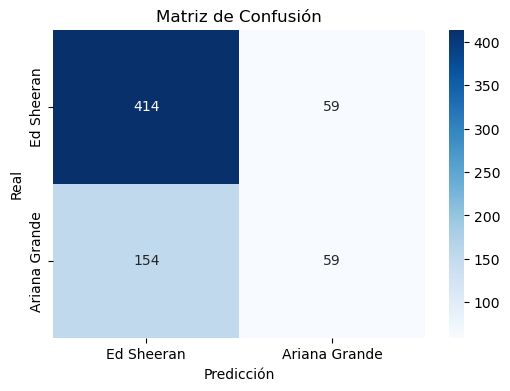

In [75]:
# Crear la variable objetivo (popularidad relativa)
def relative_popularity(row):
    if row['artist'] == 'Ariana Grande':
        return 1  # Ariana Grande es más popular
    else:
        return 0  # Ed Sheeran es más popular

df_filtrado = df_filtrado.copy()

df_filtrado.loc[:, 'relative_popularity'] = df_filtrado.apply(relative_popularity, axis=1)

# Codificar variables categóricas
le = LabelEncoder()

df_filtrado.loc[:, 'region_encoded'] = le.fit_transform(df_filtrado['region'])

# Seleccionar características relevantes
features = ['region_encoded', 'rank', 'streams']  # Ajusta según tus necesidades
target = 'relative_popularity'

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df_filtrado[features], df_filtrado[target], test_size=0.2, random_state=5
)

# Código para utilizar algoritmo de Random Forest con los hiperparámetros óptimos proporcionados
model = RandomForestClassifier(
    n_estimators=75,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=30,
    random_state=5
)

model.fit(X_train, y_train)

# Predicciones realizadas
y_pred = model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo Random Forest: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=['Ed Sheeran', 'Ariana Grande']))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Ed Sheeran', 'Ariana Grande'], yticklabels=['Ed Sheeran', 'Ariana Grande'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

#### Como se puede ver, aun con los mejores parámetros encontrados, el valor de precisión del algoritmo da resultados poco alentadores. Como alternativa, se utilizará un método diferente del algoritmo random forest y sin aplicar Random Search, como para ver qué resultados da sin utilizar hiperparámetros. Se analizará con regresión logística.

Precisión del modelo: 0.5510204081632653
               precision    recall  f1-score   support

   Ed Sheeran       0.73      0.56      0.63       473
Ariana Grande       0.35      0.54      0.43       213

     accuracy                           0.55       686
    macro avg       0.54      0.55      0.53       686
 weighted avg       0.61      0.55      0.57       686



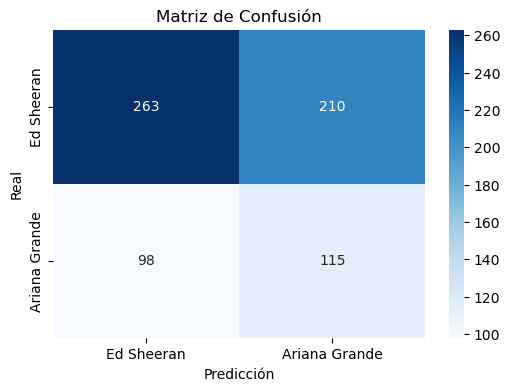

In [77]:
# Se utiliza la misma variable objetivo (popularidad relativa) creada para el análisis anterior, relative_popularity:

# 4. Crear y entrenar el modelo
model = LogisticRegression(class_weight='balanced')

model.fit(X_train, y_train)

# Predicciones realizadas
y_pred = model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy}")

print(classification_report(y_test, y_pred, target_names=['Ed Sheeran', 'Ariana Grande']))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Ed Sheeran', 'Ariana Grande'], yticklabels=['Ed Sheeran', 'Ariana Grande'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

#### Como se puede observar, el valor de precisión fue algo menor respecto al usado en random forest. Esto no significa que el sistema de hiperparámetros no sea tan efectivo, sino que, en realidad, el dataset no dispone de suficiente información en el mismo como para poder predecir la popularidad que va a tener una canción. A su vez, se pueden ver valores similares en la precisión cuando se trata de Ed Sheeran, aunque los de Ariana Grande disminuyen respecto al caso anterior.

# CONCLUSIONES

#### Como conclusiones, se puede inferir en que, si bien algunas hipótesis se cumplieron, porque se sabe que un artista es más famoso que otro, aun así se encontraron sorpresas en la forma de reproducciones como así también en la relación entre ranking y reproducciones. Por suerte, el gráfico aclaró toda duda y hasta se puede justificar la forma de la relación entre ambas variables.

#### Respecto al uso de algoritmos de clasificación utilizados para determinar la popularidad de una canción, lo cual dio valores muy bajos de preción (0.57), explicándose por el hecho de que el dataset carece de información relevante a la hora de poder predecir la popularidad de una canción, como ritmo, estilo de moda, bailabilidad, etc.

#### Finalmente, se aplicó hiperparámetros para obtener los valores óptimos para el algoritmo de random forest y determinar si, en función de la cantidad de vistas (streams), ranking y regiones se podría determinar si la canción era de Ed Sheeran o Ariana Grande y los resultados dieron, por encima del 70% para Ed Sheeran y el 50% para Ariana Grande. Por otro lado, se utilizó un segundo algoritmo (regresión logística) con parámetros estándares y, si bien la precisión bajó (demostrando la utilidad de usar hiperparámetros a la hora de definir parámetros para algoritmos de machine learning, volvió a dar preción por encima del 70% para Ed Sheeran y una preción del 35% (15% menor al caso anterior) para Ariana Grande.

#### Como conclusión, se puede inferir en que estos valores de predicción están asociados muy probablemente a un desbalance de clase, que estaría relacionado a que Ed Sheeran creó más canciones que Ariana Grande, como se pudo observar en el análisis anterior. Esto lógicamente afecta al algoritmo de predicción, ya que estaría generando un desbalance de clases. También se puede notar que Ariana Grande experimentó un nivel promedio de vistas mayor a Ed Sheeran a lo largo del período observable en el dataset. Para todos los demás análisis, se puede sacar como conclusión que Ed Sheeran y Ariana Grande son artistas con un nivel parecido de fama a nivel mundial, puesto que sus canciones son escuchadas en los mismos países. 